In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params
from lsst.all_sky_phot.star_catalog import read_simbad
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture

from scipy.spatial import KDTree
import healpy as hp
from lsst.sims.utils import healbin

In [2]:
# read in the file that has manual locations of stars
names = ['star_name', 'x', 'y', 'filename']
types = ['|U10', float, float, '|U30']
rough_positions = np.loadtxt('star_coords.dat', dtype=list(zip(names, types)), skiprows=1)

In [3]:
# figure out what MJD each file was taken at
ufiles, files_inverse = np.unique(rough_positions['filename'], return_inverse=True)
mjds = []
# UT offset for Arizona
utc_offset = 7/24. # in days.
for filename in ufiles:
    hdu1 = fits.open('2018-01-26/'+filename)
    # This says UT, but I think it's AZ time
    date_string = hdu1[0].header['DATE-OBS']
    time_obj = Time(date_string, scale='utc')
    mjds.append(time_obj.mjd+utc_offset)
    hdu1.close()

In [4]:
# grab the location from the header
hdu1 = fits.open('2018-01-26/'+ufiles[0])
lat = Latitude(hdu1[0].header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(hdu1[0].header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)
hdu1.close()

In [5]:
all_mjds = [mjds[i] for i in files_inverse]
coords = star2altaz(rough_positions['star_name'], all_mjds, location=PI_backyard)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/units/quantity.py:1000: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return super(Quantity, self).__eq__(other)


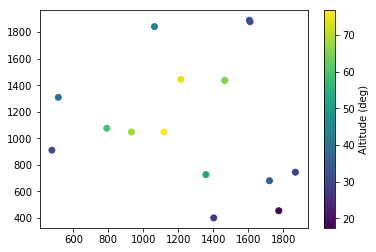

In [11]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['alt'])
cb = plt.colorbar()
cb.set_label('Altitude (deg)')

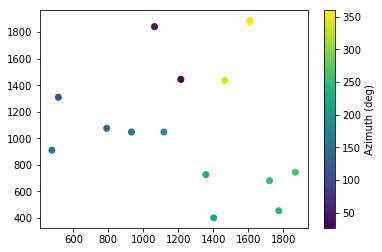

In [12]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['az'])
cb= plt.colorbar()
cb.set_label('Azimuth (deg)')

In [13]:
fun = wcs_zea(rough_positions['x'], rough_positions['y'], coords['alt'], coords['az'],
              crpix1=1202, crpix2=1214)
# Man, figuring out good initial guess for this is a pain in the ass...
x0 = np.array([1200, 1200,  0.5,0.5, 0.1, -0.06,  0.07,   0.1])
fit_result = minimize(fun, x0)
fit_result.x

array([  1.20047959e+03,   1.21568118e+03,   3.33474619e-01,
         3.81628854e-01,   1.83022675e-01,  -1.08992988e-01,
         9.44607249e-02,   1.59506838e-01])

In [14]:
# Convert the fit to a full WCS object
wcs_initial = fun.return_wcs(fit_result.x)

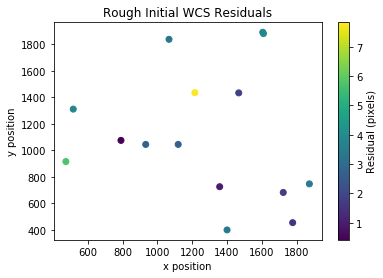

In [15]:
# Check the residuals
fit_x, fit_y = wcs_initial.all_world2pix(coords['az'], coords['alt'], 0)
resid_d = ((fit_x-rough_positions['x'])**2+(fit_y-rough_positions['y'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')

In [16]:
# Read in a catalog of bright stars from Simbad
bsc = read_simbad()

In [17]:
# load up a dark time L3 image
filename = '2018-02-05/2018_02_05__21_25_15.fits'
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [32]:
# Set photometry paramters
phot_params = default_phot_params()
phot_params['dao_fwhm'] = 2.0
phot_params['dao_thresh'] = 8.
# Measure peaks in the image
phot_table = phot_image(image, phot_params=phot_params)

In [33]:
phot_appertures = CircularAperture( (phot_table['xcenter'], phot_table['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_table['residual_aperture_sum'].data) - zp

In [34]:
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(bsc['RA'], bsc['dec'], mjd, location=PI_backyard)
above = np.where(alt_cat > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

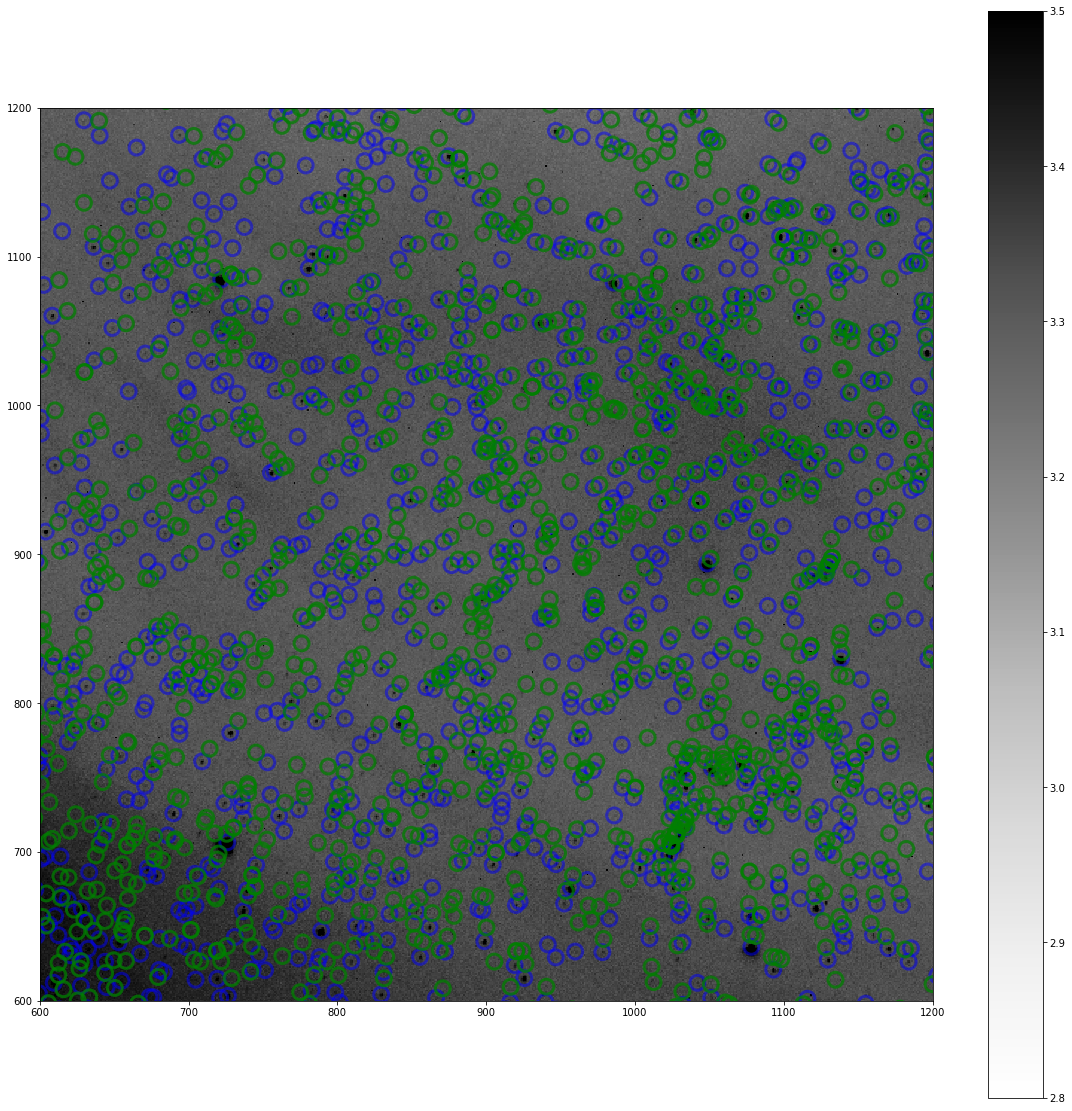

In [35]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
plt.xlim([600, 1200])
plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [64]:
# Let's set some thresholds 
good_cat = np.where((alt_cat > 15.) & (bsc['Vmag'] < 5.5))
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

good_phot = np.where(measured_mags < 9.5)
phot_appertures = CircularAperture( (phot_table['xcenter'][good_phot], phot_table['ycenter'][good_phot]), r=5.)


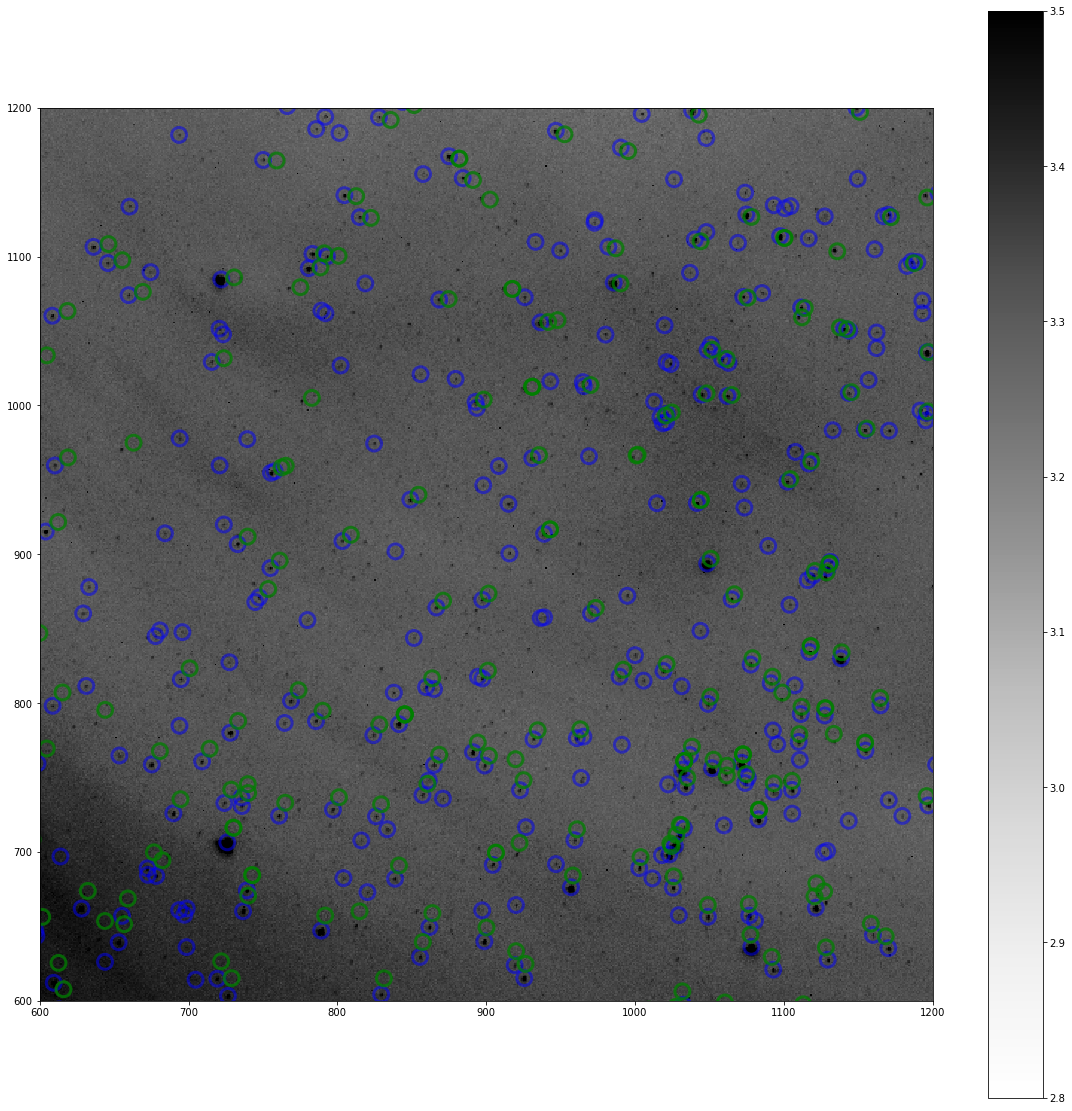

In [65]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
plt.xlim([600, 1200])
plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

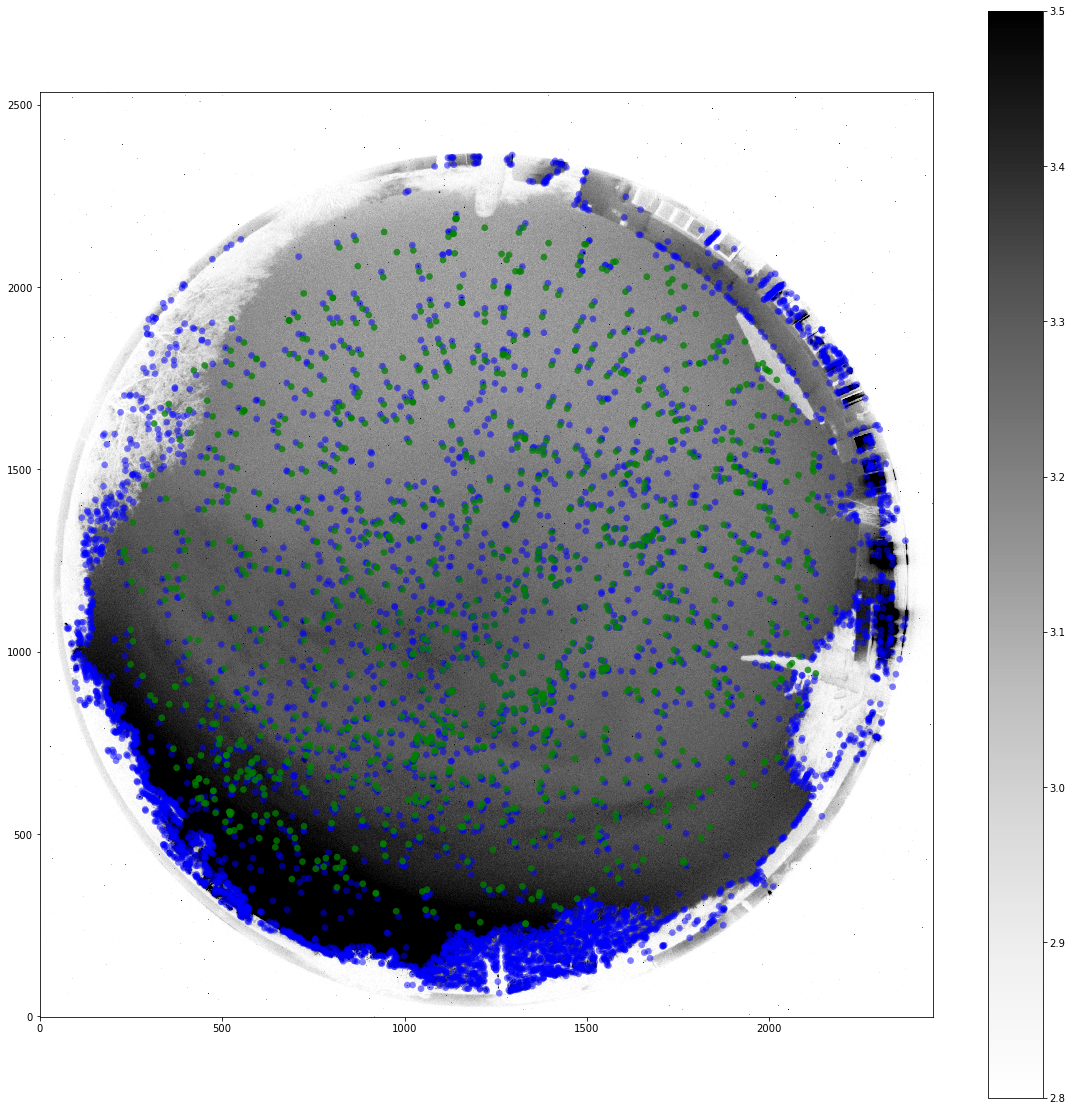

In [66]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
#plt.xlim([600, 1200])
#plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [ ]:
class star2detect_wcs_fit(object)
    def __init__(self, detectx, detecty, star_alt, star_az, wcs):
        """Wrapper to project stars to x,y plane using WCS and compute median distance to nearest neighbor.
        """
        self.star_az = star_az
        self.star_alt = star_alt
        self.wcs_init = wcs
        
        
    def __call__(self, x):
        # Make a wcs based on the new x
        
        # Project with the new WCS
        cat_x, cat_y = new_wcs.all_world2pix(self.star_az, self.star_alt, 0.)
        
        # 

In [67]:
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 1200.4795883327133  1215.6811767519325  
PC1_1 PC1_2  : 0.183022675076709  -0.10899298818519998  
PC2_1 PC2_2  : 0.09446072487723324  0.15950683790493522  
CDELT : 0.33347461878488716  0.38162885433999882  
NAXIS : 0  0